In [1]:
import re
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score,)
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [2]:
dataset = pd.read_csv('datasets\story_emotion4.csv', encoding='ISO-8859-1')
stemmer = pd.read_csv('datasets\stem_tl.csv')
word_to_stem = dict(zip(stemmer['word'], stemmer['stem']))

replace_patterns = {
    re.compile(r"\bngayo\'y\b"): 'ngayon ay',
    re.compile(r"\bhangga\'t\b"): 'hanggang',
    re.compile(r"\b\'?y\b"): ' ay',
    re.compile(r"\b\'?t\b"): ' at',
    re.compile(r"\b\'?yan\b"): 'iyan',
    re.compile(r"\b\'?yo\b"): 'iyo',
    re.compile(r"\b\'?yon\b"): 'iyon',
    re.compile(r"\b\'?yun\b"): 'iyun',
    re.compile(r"\b\'?pagkat\b"): 'sapagkat',
    re.compile(r"\b\'?di\b"): 'hindi',
    re.compile(r"\b\'?kaw\b"): "ikaw",
    re.compile(r"\b\'?to\b"): 'ito',
    re.compile(r"\b\'?wag\b"): 'huwag',
    re.compile(r"\bgano\'n\b"): 'ganoon'
}

class_names = {
    1: 'fear',
    2: 'anger',
    3: 'joy',
    4: 'sadness',
    5: 'disgust',
    6: 'surprise'
}
def data_preprocess(text, replace_patterns, word_to_stem):
    text = text.lower()

    for pattern, replacement in replace_patterns.items():
        text = pattern.sub(replacement, text)

    text = re.sub("[^a-zA-Z\s?!.]", '', text)
    tokens = word_tokenize(text)
    text = ' '.join([word_to_stem.get(word, word) for word in tokens])

    return text

dataset['text_preprocessed'] = dataset['text'].apply(data_preprocess, replace_patterns=replace_patterns, word_to_stem=word_to_stem)

X = dataset['text']
Y = dataset['emotion']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_vectorized)
X_test_tfidf = tfidf_transformer.transform(X_test_vectorized)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, Y_train)
Y_pred = nb_classifier.predict(X_test_tfidf)

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy of MNB:", accuracy)
print("\nClassification Report:\n", classification_report(Y_test, Y_pred, target_names=class_names.values()))

Accuracy of MNB: 0.8416666666666667

Classification Report:
               precision    recall  f1-score   support

        fear       0.92      0.82      0.87        40
       anger       0.87      0.82      0.85        40
         joy       0.79      0.82      0.80        40
     sadness       0.73      0.80      0.76        40
     disgust       0.89      0.85      0.87        40
    surprise       0.88      0.93      0.90        40

    accuracy                           0.84       240
   macro avg       0.85      0.84      0.84       240
weighted avg       0.85      0.84      0.84       240



In [3]:
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
    'fit_prior': [True, False],
}

grid_search = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_tfidf, Y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Best Parameters:  {'alpha': 0.1, 'fit_prior': True}
Best Accuracy:  0.7791666666666667


In [4]:
nb_classifier = MultinomialNB(alpha=0.1,fit_prior='True')
nb_classifier.fit(X_train_tfidf, Y_train)

Y_pred = nb_classifier.predict(X_test_tfidf)

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy of MNB:", accuracy)
print("\nClassification Report:\n", classification_report(Y_test, Y_pred, target_names=class_names.values()))

Accuracy of MNB: 0.8416666666666667

Classification Report:
               precision    recall  f1-score   support

        fear       0.83      0.85      0.84        40
       anger       0.89      0.78      0.83        40
         joy       0.76      0.78      0.77        40
     sadness       0.77      0.90      0.83        40
     disgust       0.92      0.85      0.88        40
    surprise       0.92      0.90      0.91        40

    accuracy                           0.84       240
   macro avg       0.85      0.84      0.84       240
weighted avg       0.85      0.84      0.84       240



In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# K-Fold Cross-Validation loop
for fold, (train_index, test_index) in enumerate(skf.split(X, Y)):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    Y_train_fold, Y_test_fold = Y.iloc[train_index], Y.iloc[test_index]

    # Data preprocessing and vectorization for each fold
    X_train_vectorized_fold = vectorizer.fit_transform(X_train_fold)
    X_test_vectorized_fold = vectorizer.transform(X_test_fold)

    X_train_tfidf_fold = tfidf_transformer.fit_transform(X_train_vectorized_fold)
    X_test_tfidf_fold = tfidf_transformer.transform(X_test_vectorized_fold)

    # SVM classifier for each fold
    nb_classifier = MultinomialNB(alpha=0.1,fit_prior='True')
    nb_classifier.fit(X_train_tfidf_fold, Y_train_fold)

    # Predict the labels for the test set of this fold
    Y_pred_fold = nb_classifier.predict(X_test_tfidf_fold)

    # Evaluate performance metrics for this fold
    accuracy_scores.append(accuracy_score(Y_test_fold, Y_pred_fold))
    precision_scores.append(precision_score(Y_test_fold, Y_pred_fold, average='weighted'))
    recall_scores.append(recall_score(Y_test_fold, Y_pred_fold, average='weighted'))
    f1_scores.append(f1_score(Y_test_fold, Y_pred_fold, average='weighted'))

# Calculate and print average performance metrics across all folds
print(f'Average Accuracy: {np.mean(accuracy_scores)}')
print(f'Average Precision: {np.mean(precision_scores)}')
print(f'Average Recall: {np.mean(recall_scores)}')
print(f'Average F1 Score: {np.mean(f1_scores)}')


Average Accuracy: 0.7975
Average Precision: 0.8038334965305607
Average Recall: 0.7975
Average F1 Score: 0.798165502706758


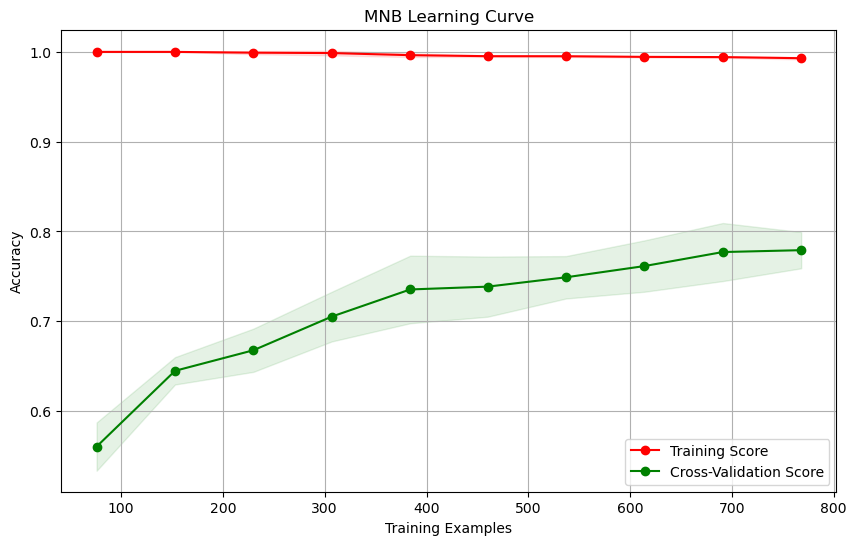

In [6]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    nb_classifier, X_train_tfidf, Y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("MNB Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()


In [7]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for fold, (train_index, test_index) in enumerate(skf.split(X, Y)):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    Y_train_fold, Y_test_fold = Y.iloc[train_index], Y.iloc[test_index]

    X_train_vectorized_fold = vectorizer.fit_transform(X_train_fold)
    X_test_vectorized_fold = vectorizer.transform(X_test_fold)

    X_train_tfidf_fold = tfidf_transformer.fit_transform(X_train_vectorized_fold)
    X_test_tfidf_fold = tfidf_transformer.transform(X_test_vectorized_fold)

    nb_classifier = MultinomialNB(alpha=1.5,fit_prior='True')
    nb_classifier.fit(X_train_tfidf, Y_train)

    nb_classifier.fit(X_train_tfidf_fold, Y_train_fold)

    Y_pred_fold = nb_classifier.predict(X_test_tfidf_fold)

    accuracy_scores.append(accuracy_score(Y_test_fold, Y_pred_fold))
    precision_scores.append(precision_score(Y_test_fold, Y_pred_fold, average='weighted'))
    recall_scores.append(recall_score(Y_test_fold, Y_pred_fold, average='weighted'))
    f1_scores.append(f1_score(Y_test_fold, Y_pred_fold, average='weighted'))

print(f'Average Accuracy: {np.mean(accuracy_scores)}')
print(f'Average Precision: {np.mean(precision_scores)}')
print(f'Average Recall: {np.mean(recall_scores)}')
print(f'Average F1 Score: {np.mean(f1_scores)}')


Average Accuracy: 0.7925000000000001
Average Precision: 0.7973342073051818
Average Recall: 0.7925000000000001
Average F1 Score: 0.7926851124937255


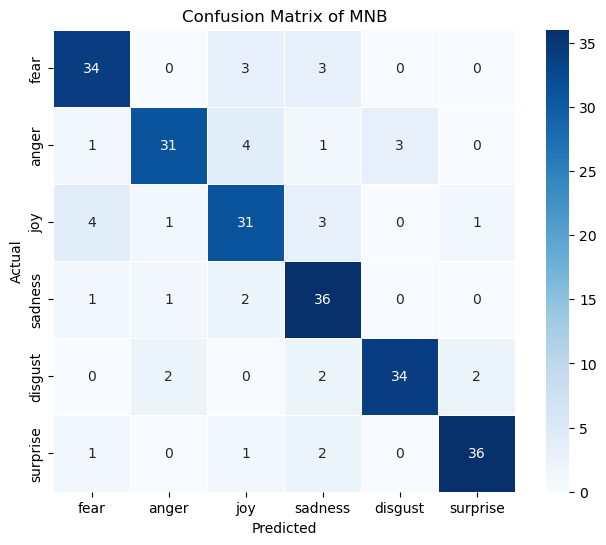

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(Y_test, Y_pred)

conf_df = pd.DataFrame(conf_matrix, index=class_names.values(), columns=class_names.values())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, square=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of MNB')
plt.show()
